In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm
import time
import gc

In [ ]:
def extract_data_if_needed():
    if not (Path('./etfs').exists() or not Path('./stocks').exists()):
        zip_path = Path('./etfs.zip')
        if zip_path.exists():
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('./')
            print("Extracted data files from etfs.zip")
        else:
            raise FileNotFoundError("Neither processed data nor source zip file found")

In [ ]:
def load_preprocessed_data(folder_path='processed_datasets', min_entries=30):
    dfs = {}
    if os.path.exists(folder_path):
        csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        
        for filename in tqdm(csv_files, desc="Loading preprocessed data"):
            try:
                filepath = os.path.join(folder_path, filename)
                df = pd.read_csv(filepath, parse_dates=['Date'])
                
                if not df['Date'].is_monotonic_increasing:
                    df = df.sort_values('Date')
                
                if len(df) >= min_entries:
                    ticker = filename.replace('.csv', '')
                    dfs[ticker] = df
            except Exception as e:
                print(f"\nError loading {filename}: {e}")
    
    return dfs

In [ ]:
def add_features(df):

    df['Daily_Return'] = df['Close'].pct_change()
    
    df['Volume_MA_10'] = df['Volume'].rolling(10).mean()
    df['Volume_Change'] = df['Volume'].pct_change()
    
    df['SMA_10'] = df['Close'].rolling(10).mean()
    
    df['Volatility'] = df['Daily_Return'].rolling(20).std()
    
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    
    df['Target'] = df['Close'].shift(-1)
    
    return df

def add_classification_target(df):
    df['Price_Up'] = (df['Target'] > df['Close']).astype(int)
    return df

In [ ]:
def process_raw_data(min_entries=30):
    dfs = {}
    base_path = Path("./")
    all_files = list((base_path / "stocks").glob("*.csv")) + list((base_path / "etfs").glob("*.csv"))
    
    for file_path in tqdm(all_files, desc="Processing raw data"):
        try:
            df = pd.read_csv(file_path, parse_dates=['Date'])
            
            if not df['Date'].is_monotonic_increasing:
                df = df.sort_values('Date')
            
            if len(df) >= min_entries:
                df = add_features(df)
                df = add_classification_target(df)
                df = df.dropna()
                
                if len(df) >= min_entries:
                    ticker = file_path.stem
                    dfs[ticker] = df
        except Exception as e:
            print(f"\nError processing {file_path.name}: {e}")
    
    return dfs

In [ ]:
def save_processed_data(dfs, folder_path='processed_datasets'):
    os.makedirs(folder_path, exist_ok=True)
    for ticker, df in dfs.items():
        df.to_csv(f'{folder_path}/{ticker}.csv', index=False)

In [21]:
if not Path('processed_datasets').exists() or not any(f.endswith('.csv') for f in os.listdir('processed_datasets')):
    print("No processed data found - processing from raw files")
    extract_data_if_needed()
    dfs = process_raw_data()
    if dfs:
        save_processed_data(dfs)
        print(f"Processed and saved {len(dfs)} datasets")
    else:
        print("No valid datasets found after processing")
else:
    print("Loading existing processed data")
    dfs = load_preprocessed_data()

if dfs:
    print("\nData Verification:")
    print("="*50)
    sample_ticker = list(dfs.keys())[0]
    sample_df = dfs[sample_ticker]
    
    print(f"\nSample dataset ({sample_ticker}):")
    print(f"- Total entries: {len(sample_df)}")
    print(f"- Date range: {sample_df['Date'].min()} to {sample_df['Date'].max()}")
    print(f"- Columns: {list(sample_df.columns)}")
    
    print("\nMissing values check:")
    print(sample_df.isnull().sum())
    
    print("\nChronological order verified:", sample_df['Date'].is_monotonic_increasing)
    
    print("\nSample data:")
    print(sample_df.head(3))
else:
    print("\nNo valid datasets loaded")

No processed data found - processing from raw files


Processing raw data: 100%|██████████| 10415/10415 [05:00<00:00, 34.65it/s]


Processed and saved 10048 datasets

Data Verification:

Sample dataset (A):
- Total entries: 1232
- Date range: 2020-05-19 00:00:00 to 2025-04-11 00:00:00
- Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'Volume_MA_10', 'Volume_Change', 'SMA_10', 'Volatility', 'RSI', 'Day_of_Week', 'Month', 'Target', 'Price_Up']

Missing values check:
Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
Daily_Return     0
Volume_MA_10     0
Volume_Change    0
SMA_10           0
Volatility       0
RSI              0
Day_of_Week      0
Month            0
Target           0
Price_Up         0
dtype: int64

Chronological order verified: True

Sample data:
         Date      Close       High        Low       Open   Volume  \
20 2020-05-19  79.248337  80.766208  79.170991  80.466503  2099200   
21 2020-05-20  78.996986  80.224823  78.764957  80.224823  2748100   
22 2020-05-21  78.068848  79.461038  77.788476  79.006642

In [ ]:
def calculate_instrument_features(df):
    return {
        'avg_daily_return': df['Daily_Return'].mean(),
        'volatility': df['Daily_Return'].std(),
        'avg_volume': df['Volume'].mean(),
        'price_range': df['Close'].max() - df['Close'].min()
    }

=== Clustering Evaluation with Outlier Detection ===
n_clusters = 2: Silhouette = nan, Calinski-Harabasz = nan, Non-outliers = 0.0%
n_clusters = 3: Silhouette = nan, Calinski-Harabasz = nan, Non-outliers = 0.0%
n_clusters = 4: Silhouette = nan, Calinski-Harabasz = nan, Non-outliers = 0.0%
n_clusters = 5: Silhouette = nan, Calinski-Harabasz = nan, Non-outliers = 0.0%
n_clusters = 6: Silhouette = nan, Calinski-Harabasz = nan, Non-outliers = 0.0%
n_clusters = 7: Silhouette = 0.917, Calinski-Harabasz = 10455.844, Non-outliers = 99.8%
n_clusters = 8: Silhouette = 0.909, Calinski-Harabasz = 15140.020, Non-outliers = 99.7%
n_clusters = 9: Silhouette = 0.893, Calinski-Harabasz = 14972.375, Non-outliers = 99.5%
n_clusters = 10: Silhouette = 0.856, Calinski-Harabasz = 13936.279, Non-outliers = 98.9%
n_clusters = 11: Silhouette = 0.798, Calinski-Harabasz = 13634.526, Non-outliers = 99.2%
n_clusters = 12: Silhouette = 0.795, Calinski-Harabasz = 13381.711, Non-outliers = 99.1%
n_clusters = 13: Silh

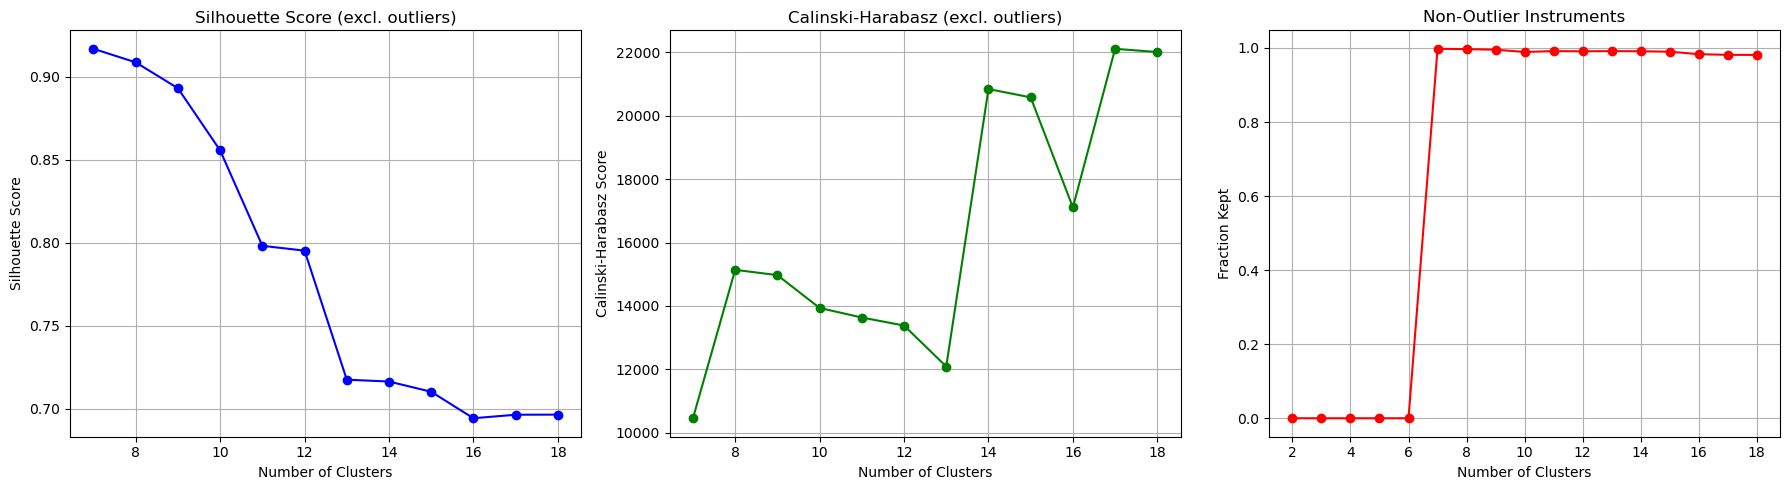


Clustering Evaluation Results (outliers excluded):


,n_clusters,Silhouette,Calinski-Harabasz,Non_outlier_fraction
0,2,nan,nan,0.0%
1,3,nan,nan,0.0%
2,4,nan,nan,0.0%
3,5,nan,nan,0.0%
4,6,nan,nan,0.0%
5,7,0.917,10455.8,99.8%
6,8,0.909,15140.0,99.7%
7,9,0.893,14972.4,99.5%
8,10,0.856,13936.3,98.9%
9,11,0.798,13634.5,99.2%



=== Outlier Identification ===

Cluster distribution (n_clusters=18):
cluster
0     7989
12    1270
9      418
15     183
6       78
14      41
16      20
10      17
5       11
17       7
13       3
8        3
2        2
11       2
1        1
4        1
3        1
7        1

Identified 188 outliers (clusters with <100 instruments):


,avg_daily_return,volatility,avg_volume,price_range,cluster
count,188.00,188.00,188.00,188.00,188.00
mean,0.06,1.86,22922816.54,1555470.00,9.63
std,0.46,14.83,35572279.41,15050946.47,4.36
min,-0.05,0.00,8659.68,0.92,1.00
25%,0.00,0.02,11596147.36,19.23,6.00
50%,0.00,0.04,15106732.35,42.61,6.50
75%,0.00,0.07,24681845.58,101.01,14.00
max,5.73,185.49,431564323.54,151999997.12,17.00



Saved cluster assignments to 'cluster_assignments.csv'
Final number of main clusters (non-outliers): 4

Main clusters contain 9860 instruments


In [88]:
def evaluate_clusters_with_outliers(dfs, max_clusters=18, outlier_threshold=0.01):

    instrument_features = {}
    for ticker, df in dfs.items():
        instrument_features[ticker] = calculate_instrument_features(df)
    
    features_df = pd.DataFrame.from_dict(instrument_features, orient='index')
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    
    cluster_range = range(2, max_clusters+1)
    silhouette_scores = []
    calinski_scores = []
    cluster_quality = []
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_features)
        
        cluster_counts = pd.Series(cluster_labels).value_counts()
        min_cluster_size = len(features_df) * outlier_threshold
        non_outliers = cluster_counts[cluster_counts >= min_cluster_size].index
        
        if len(non_outliers) > 1:
            mask = np.isin(cluster_labels, non_outliers)
            sil_score = silhouette_score(scaled_features[mask], cluster_labels[mask])
            cal_score = calinski_harabasz_score(scaled_features[mask], cluster_labels[mask])
            quality = mask.sum()/len(features_df)
        else:
            sil_score, cal_score, quality = np.nan, np.nan, 0
        
        silhouette_scores.append(sil_score)
        calinski_scores.append(cal_score)
        cluster_quality.append(quality)
        
        print(f"n_clusters = {n_clusters}: "
              f"Silhouette = {sil_score:.3f}, "
              f"Calinski-Harabasz = {cal_score:.3f}, "
              f"Non-outliers = {quality:.1%}")

    _ , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    ax1.plot(cluster_range, silhouette_scores, 'bo-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Score (excl. outliers)')
    ax1.grid(True)
    
    ax2.plot(cluster_range, calinski_scores, 'go-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Calinski-Harabasz Score')
    ax2.set_title('Calinski-Harabasz (excl. outliers)')
    ax2.grid(True)
    
    ax3.plot(cluster_range, cluster_quality, 'ro-')
    ax3.set_xlabel('Number of Clusters')
    ax3.set_ylabel('Fraction Kept')
    ax3.set_title('Non-Outlier Instruments')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    results_df = pd.DataFrame({
        'n_clusters': cluster_range,
        'Silhouette': silhouette_scores,
        'Calinski-Harabasz': calinski_scores,
        'Non_outlier_fraction': cluster_quality
    })
    
    print("\nClustering Evaluation Results (outliers excluded):")
    display(results_df.style.format({
        'Silhouette': '{:.3f}',
        'Calinski-Harabasz': '{:.1f}',
        'Non_outlier_fraction': '{:.1%}'
    }).background_gradient(cmap='Blues'))
    
    return results_df

def get_outliers(dfs, n_clusters=18, outlier_threshold=0.01):
    instrument_features = {}
    for ticker, df in dfs.items():
        instrument_features[ticker] = calculate_instrument_features(df)
    
    features_df = pd.DataFrame.from_dict(instrument_features, orient='index')
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    features_df['cluster'] = cluster_labels
    
    cluster_counts = features_df['cluster'].value_counts()
    min_size = len(features_df) * outlier_threshold
    outlier_clusters = cluster_counts[cluster_counts < min_size].index
    
    features_df['is_outlier'] = features_df['cluster'].isin(outlier_clusters)

    cluster_summary = features_df.copy()
    cluster_summary.index.name = 'ticker'
    cluster_summary.reset_index(inplace=True)
    cluster_summary.to_csv("cluster_assignments.csv", index=False)
    
    main_clusters = cluster_summary[~cluster_summary['is_outlier']]
    outliers = cluster_summary[cluster_summary['is_outlier']]
    
    print(f"\nCluster distribution (n_clusters={n_clusters}):")
    print(cluster_counts.to_string())

    print(f"\nIdentified {len(outliers)} outliers (clusters with <{min_size:.0f} instruments):")
    if not outliers.empty:
        display(outliers.describe().style.format("{:.2f}"))
    
    print(f"\nSaved cluster assignments to 'cluster_assignments.csv'")
    print(f"Final number of main clusters (non-outliers): {main_clusters['cluster'].nunique()}")
    
    return main_clusters, outliers

if dfs:
    print("=== Clustering Evaluation with Outlier Detection ===")
    eval_results = evaluate_clusters_with_outliers(dfs)
    
    print("\n=== Outlier Identification ===")
    main_data, outliers = get_outliers(dfs, n_clusters=18)
    
    print(f"\nMain clusters contain {len(main_data)} instruments")
else:
    print("No datasets available for clustering evaluation")

In [65]:
def prepare_consistent_data(dfs, main_clusters, outliers, test_size=0.2):

    clustered_data = {}
    last_entries = {}
    
    def prepare_features(df):

        features = df.drop(['Price_Up', 'Target', 'Date'], axis=1, errors='ignore')
        
        for col in features.select_dtypes(include=['float64']):
            if features[col].abs().max() > 1e6:
                features[col] = features[col] / 1e6
            elif features[col].astype(str).str.split('.').str[1].str.len().max() > 6:
                features[col] = features[col].round(6)
        
        features = features.astype(np.float32)
        features = features.replace([np.inf, -np.inf], np.nan)
        features = features.fillna(features.median())
        
        return features
    
    for cluster_id in main_clusters['cluster'].unique():
        cluster_tickers = main_clusters[main_clusters['cluster'] == cluster_id].index
        X_train, y_train = [], []
        X_test, y_test = [], []
        
        for ticker in cluster_tickers:
            if ticker in dfs:
                df = dfs[ticker]
                features = prepare_features(df)
                target = df['Target']
                
                split_idx = int(len(df) * (1 - test_size))
                
                X_train.append(features.iloc[:split_idx])
                y_train.append(target.iloc[:split_idx])
                X_test.append(features.iloc[split_idx:])
                y_test.append(target.iloc[split_idx:])
                
                last_entries[ticker] = features.iloc[[-1]]
        
        if X_train:
            clustered_data[cluster_id] = (
                pd.concat(X_train),
                pd.concat(y_train),
                pd.concat(X_test),
                pd.concat(y_test)
            )
    
    if not outliers.empty:
        outlier_tickers = outliers.index
        X_train, y_train = [], []
        X_test, y_test = [], []
        
        for ticker in outlier_tickers:
            if ticker in dfs:
                df = dfs[ticker]
                features = prepare_features(df)
                target = df['Target']
                
                split_idx = int(len(df) * (1 - test_size))
                
                X_train.append(features.iloc[:split_idx])
                y_train.append(target.iloc[:split_idx])
                X_test.append(features.iloc[split_idx:])
                y_test.append(target.iloc[split_idx:])
                
                last_entries[ticker] = features.iloc[[-1]]
        
        if X_train:
            clustered_data['outliers'] = (
                pd.concat(X_train),
                pd.concat(y_train),
                pd.concat(X_test),
                pd.concat(y_test)
            )
    
    return clustered_data, last_entries

if 'main_data' in locals() and 'outliers' in locals():

    clustered_datasets, final_predictions = prepare_consistent_data(dfs, main_data, outliers)
    
    cluster_0_data = clustered_datasets.get(0, None)
    if cluster_0_data:
        X_train_0, y_train_0, X_test_0, y_test_0 = cluster_0_data
        print(f"\nCluster 0 shapes:")
        print(f"Train: {X_train_0.shape}, {y_train_0.shape}")
        print(f"Test: {X_test_0.shape}, {y_test_0.shape}")
    
    print("\nLast entries ready for prediction:")
    print(f"Total tickers: {len(final_predictions)}")
    example_ticker = list(final_predictions.keys())[0]
    print(f"Example last entry for {example_ticker}:")
    display(final_predictions[example_ticker].head())
    
    for cluster_id, (X_train, _, X_test, _) in clustered_datasets.items():
        print(f"\nCluster {cluster_id} value ranges:")
        print("Train stats:")
        print(X_train.describe().loc[['min', 'max', 'mean']])
        print("\nTest stats:")
        print(X_test.describe().loc[['min', 'max', 'mean']])


Cluster 0 shapes:
Train: (5961850, 13), (5961850,)
Test: (1495376, 13), (1495376,)

Last entries ready for prediction:
Total tickers: 10048
Example last entry for A:


,Close,High,Low,Open,Volume,Daily_Return,Volume_MA_10,Volume_Change,SMA_10,Volatility,RSI,Day_of_Week,Month
1251,102.709999,103.339996,98.860001,101.150002,2848600.0,0.027614,3.40421,-0.427739,107.203201,0.032859,29.201674,4.0,4.0



Cluster 12 value ranges:
Train stats:
              Close           High            Low           Open  \
min        0.133000       0.145000       0.120000       0.130000   
max   183936.000000  199200.000000  182400.000000  194976.000000   
mean      98.909142     101.789154      96.592384      99.341454   

            Volume  Daily_Return  Volume_MA_10  Volume_Change         SMA_10  \
min   0.000000e+00     -0.898685  1.000000e-07      -0.999964       0.144200   
max   7.436805e+08     16.342106  1.243261e+02   39687.000000  165148.796875   
mean  1.429547e+06      0.000748  1.429227e+00       0.361322      99.490028   

      Volatility         RSI  Day_of_Week      Month  
min     0.000018    0.000000     0.000000   1.000000  
max     3.661866  100.000000     4.000000  12.000000  
mean    0.030321   51.068977     2.029471   6.582562  

Test stats:
            Close         High          Low         Open        Volume  \
min      0.009000     0.011000     0.007000     0.010000  0.

In [ ]:
def debug_invalid_values(X, y, cluster_id, ticker_index=None):
    invalid_found = False
    duplicate_cols = X.columns[X.columns.duplicated()].tolist()

    if duplicate_cols:
        print(f"\n[Warning] Duplicate columns found: {duplicate_cols}")

    X = X.loc[:, ~X.columns.duplicated()]

    for idx, row in X.iterrows():
        if not np.all(np.isfinite(row)):
            invalid_found = True
            print(f"\n[Invalid] Value found in cluster {cluster_id}, row {idx}:")
            if ticker_index is not None:
                try:
                    ticker_name = ticker_index[idx] if isinstance(ticker_index, pd.Series) else ticker_index.iloc[idx]
                    print(f"  Ticker: {ticker_name}")
                except Exception as e:
                    print(f"  Ticker lookup failed for index {idx}: {e}")

            for col in X.columns:
                val = row[col]
                if not np.isfinite(val) or np.isnan(val) or abs(val) > np.finfo(np.float32).max:
                    print(f"    -> {col}: {val}")

    return invalid_found


In [84]:
class MemoryEfficientLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=16, num_layers=1):
        super(MemoryEfficientLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], (h_t, c_t))
        return self.linear(h_t)

def process_data_in_batches(data_generator, model, is_training=True, optimizer=None, criterion=None):

    device = next(model.parameters()).device
    total_loss = 0
    predictions = []
    true_values = []
    batch_count = 0

    for X_batch, y_batch in data_generator:
        batch_count += 1
        X_tensor = torch.FloatTensor(X_batch).to(device)
        y_tensor = torch.FloatTensor(y_batch).to(device)
        
        with torch.set_grad_enabled(is_training):
            outputs = model(X_tensor)
            if is_training:
                optimizer.zero_grad()
                loss = criterion(outputs.squeeze(), y_tensor)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
        predictions.extend(outputs.squeeze().detach().cpu().numpy())
        true_values.extend(y_batch)
        
        del X_tensor, y_tensor, outputs
        if is_training:
            del loss
        torch.cuda.empty_cache()
    
    if is_training:
        return total_loss / batch_count
    else:
        return predictions, true_values

def train_cluster_models(clustered_datasets, model_dir='cluster_models'):
    os.makedirs(model_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_models = {}
    all_metrics = {}
    
    for cluster_id, (X_train, y_train, X_test, y_test) in clustered_datasets.items():
        cluster_models = {}
        cluster_metrics = {}
        
        print(f"\n=== Processing cluster {cluster_id} ===")
        print(f"Train shapes: {X_train.shape}, {y_train.shape}")
        print(f"Test shapes: {X_test.shape}, {y_test.shape}")
        
        en_path = os.path.join(model_dir, f'cluster_{cluster_id}_en.pkl')
        if os.path.exists(en_path):
            print("Loading existing ElasticNet model")
            en_model = joblib.load(en_path)
        else:
            print("Training ElasticNet with batch processing...")
            en_model = ElasticNet(alpha=0.1, max_iter=1000, random_state=42)
            
            batch_size = 10000
            for i in tqdm(range(0, len(X_train), batch_size), desc="ElasticNet batches"):
                batch_X = X_train.iloc[i:i+batch_size]
                batch_y = y_train.iloc[i:i+batch_size]
                en_model.fit(batch_X, batch_y)
            
            joblib.dump(en_model, en_path)
        
        en_pred = en_model.predict(X_test)
        cluster_models['en'] = en_model
        cluster_metrics['en'] = {
            'MAE': mean_absolute_error(y_test, en_pred),
            'MAPE': mean_absolute_percentage_error(y_test, en_pred)
        }
        
        lgb_path = os.path.join(model_dir, f'cluster_{cluster_id}_lgb.pkl')
        if os.path.exists(lgb_path):
            print("Loading existing LightGBM model")
            lgb_model = joblib.load(lgb_path)
        else:
            print("Training LightGBM with memory-efficient settings...")
            lgb_model = LGBMRegressor(
                n_estimators=50,
                learning_rate=0.05,
                max_depth=3,
                num_leaves=7,
                verbosity=-1,
                random_state=42,
                n_jobs=1,
                max_bin=63
            )
            
            try:
                lgb_model.fit(X_train, y_train)
            except MemoryError:
                print("Falling back to batch training for LightGBM")
                batch_size = 10000
                for i in tqdm(range(0, len(X_train), batch_size), desc="LightGBM batches"):
                    batch_X = X_train.iloc[i:i+batch_size]
                    batch_y = y_train.iloc[i:i+batch_size]
                    lgb_model.fit(batch_X, batch_y, init_model=lgb_model if i > 0 else None)
            
            joblib.dump(lgb_model, lgb_path)
        
        lgb_pred = lgb_model.predict(X_test)
        cluster_models['lgb'] = lgb_model
        cluster_metrics['lgb'] = {
            'MAE': mean_absolute_error(y_test, lgb_pred),
            'MAPE': mean_absolute_percentage_error(y_test, lgb_pred)
        }
        
        lstm_path = os.path.join(model_dir, f'cluster_{cluster_id}_lstm.pt')
        if os.path.exists(lstm_path):
            print("Loading existing LSTM model")
            lstm_model = MemoryEfficientLSTM(input_size=X_train.shape[1])
            lstm_model.load_state_dict(torch.load(lstm_path))
            lstm_model.eval()
        else:
            print("Training LSTM with memory-efficient processing...")
            
            X_train_3d = X_train.values.reshape(-1, 1, X_train.shape[1]).astype(np.float32)
            X_test_3d = X_test.values.reshape(-1, 1, X_test.shape[1]).astype(np.float32)
            
            lstm_model = MemoryEfficientLSTM(input_size=X_train.shape[1]).to(device)
            
            criterion = nn.L1Loss()
            optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
            batch_size = 32
            epochs = 15
            
            def create_batches(X, y, batch_size):
                for i in range(0, len(X), batch_size):
                    yield (X[i:i+batch_size], y[i:i+batch_size])
            
            best_loss = float('inf')
            for _ in tqdm(range(epochs), desc="LSTM Training"):
                lstm_model.train()
                train_batches = create_batches(X_train_3d, y_train.values, batch_size)
                _ = process_data_in_batches(
                    train_batches, lstm_model, 
                    is_training=True, optimizer=optimizer, criterion=criterion
                )
                
                lstm_model.eval()
                val_batches = create_batches(X_test_3d, y_test.values, batch_size)
                val_preds, val_true = process_data_in_batches(
                    val_batches, lstm_model, 
                    is_training=False
                )
                val_loss = mean_absolute_error(val_true, val_preds)
                
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(lstm_model.state_dict(), lstm_path)
            
            lstm_model.load_state_dict(torch.load(lstm_path))
        
        lstm_pred = []
        eval_batch_size = 500
        X_test_3d = X_test.values.reshape(-1, 1, X_test.shape[1]).astype(np.float32)
        
        with torch.no_grad():
            lstm_model.eval()
            for i in tqdm(range(0, len(X_test_3d), eval_batch_size), desc="LSTM Evaluation"):
                batch = X_test_3d[i:i+eval_batch_size]
                batch_tensor = torch.FloatTensor(batch).to(device)
                preds = lstm_model(batch_tensor).cpu().numpy().flatten()
                lstm_pred.extend(preds)
        
        cluster_models['lstm'] = lstm_model
        cluster_metrics['lstm'] = {
            'MAE': mean_absolute_error(y_test, lstm_pred),
            'MAPE': mean_absolute_percentage_error(y_test, lstm_pred)
        }
        
        all_models[cluster_id] = cluster_models
        all_metrics[cluster_id] = cluster_metrics
        
        print(f"\nCluster {cluster_id} Metrics:")
        for model_name, metrics in cluster_metrics.items():
            print(f"{model_name.upper():>8}: MAE={metrics['MAE']:.4f}, MAPE={metrics['MAPE']:.2%}")
        
        if 'X_train_3d' in locals():
            del X_train_3d
        if 'X_test_3d' in locals():
            del X_test_3d

        gc.collect()
        torch.cuda.empty_cache()
    
    return all_models, all_metrics

if 'main_data' in locals() and 'outliers' in locals():
    print("Starting memory-optimized model training...")
    start_time = time.time()
    
    all_cluster_models = {}
    all_cluster_metrics = {}
    
    for cluster_id in clustered_datasets.keys():
        print(f"\nProcessing cluster {cluster_id}")
        models, metrics = train_cluster_models(
            {cluster_id: clustered_datasets[cluster_id]},
            model_dir='cluster_models'
        )
        all_cluster_models.update(models)
        all_cluster_metrics.update(metrics)
    
    print("\n=== Training Summary ===")
    print(f"Completed in {time.time()-start_time:.2f} seconds")
    for cluster_id, metrics in all_cluster_metrics.items():
        best_model = min(metrics.items(), key=lambda x: x[1]['MAE'])
        print(f"Cluster {cluster_id} Best: {best_model[0].upper()} (MAE={best_model[1]['MAE']:.4f})")
    
    example_ticker = list(final_predictions.keys())[0]
    if example_ticker in main_data.index:
        cluster_id = main_data.loc[example_ticker, 'cluster']
    else:
        cluster_id = 'outliers'
    
    example_data = final_predictions[example_ticker].drop(['Price_Up', 'Target', 'Date'], 
                                                        axis=1, errors='ignore')
    
    print(f"\nExample prediction for {example_ticker}:")
    for model_name, model in all_cluster_models[cluster_id].items():
        if model_name == 'lstm':
            with torch.no_grad():
                model.eval()
                input_data = example_data.values.reshape(1, 1, -1).astype(np.float32)
                input_tensor = torch.FloatTensor(input_data).to(next(model.parameters()).device)
                pred = model(input_tensor).cpu().numpy()[0][0]
        else:
            pred = model.predict(example_data.values.reshape(1, -1))[0]
        print(f"{model_name.upper():>8}: {pred:.2f}")

Starting memory-optimized model training...

Processing cluster 12

=== Processing cluster 12 ===
Train shapes: (1119070, 13), (1119070,)
Test shapes: (280634, 13), (280634,)
Loading existing ElasticNet model
Loading existing LightGBM model


C:\Users\khanh\AppData\Local\Temp\ipykernel_20672\215641571.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(lstm_path))


Loading existing LSTM model


LSTM Evaluation: 100%|██████████| 562/562 [00:00<00:00, 2263.54it/s]
C:\Users\khanh\AppData\Local\Temp\ipykernel_20672\215641571.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f


Cluster 12 Metrics:
      EN: MAE=0.9962, MAPE=7.28%
     LGB: MAE=10.1966, MAPE=289.81%
    LSTM: MAE=52.1646, MAPE=650.87%

Processing cluster 15

=== Processing cluster 15 ===
Train shapes: (164458, 13), (164458,)
Test shapes: (41244, 13), (41244,)
Loading existing ElasticNet model
Loading existing LightGBM model
Loading existing LSTM model


LSTM Evaluation: 100%|██████████| 83/83 [00:00<00:00, 2005.49it/s]


Cluster 15 Metrics:
      EN: MAE=0.9250, MAPE=2.71%
     LGB: MAE=5.6720, MAPE=104.07%
    LSTM: MAE=46.0490, MAPE=434.51%



Processing cluster 0

=== Processing cluster 0 ===
Train shapes: (5961850, 13), (5961850,)
Test shapes: (1495376, 13), (1495376,)
Loading existing ElasticNet model
Loading existing LightGBM model
Training LSTM with memory-efficient processing...


LSTM Training: 100%|██████████| 15/15 [58:23<00:00, 233.57s/it] 
C:\Users\khanh\AppData\Local\Temp\ipykernel_20672\215641571.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu


Cluster 0 Metrics:
      EN: MAE=0.7474, MAPE=5.29%
     LGB: MAE=157.3902, MAPE=48081.08%
    LSTM: MAE=26.4479, MAPE=239.40%

Processing cluster 9

=== Processing cluster 9 ===
Train shapes: (385093, 13), (385093,)
Test shapes: (96563, 13), (96563,)
Training ElasticNet with batch processing...


ElasticNet batches:   0%|          | 0/39 [00:00<?, ?it/s]d:\Applications\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.413e+04, tolerance: 1.961e+04
  model = cd_fast.enet_coordinate_descent(
d:\Applications\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.374e+03, tolerance: 4.857e+02
  model = cd_fast.enet_coordinate_descent(
ElasticNet batches:  10%|█         | 4/39 [00:00<00:02, 15.93it/s]d:\Applications\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase th

Training LightGBM with memory-efficient settings...
Training LSTM with memory-efficient processing...


LSTM Training: 100%|██████████| 15/15 [03:38<00:00, 14.60s/it]
C:\Users\khanh\AppData\Local\Temp\ipykernel_20672\215641571.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature


Cluster 9 Metrics:
      EN: MAE=0.8950, MAPE=4.39%
     LGB: MAE=9.5422, MAPE=229.61%
    LSTM: MAE=46.9082, MAPE=436.05%

Processing cluster outliers

=== Processing cluster outliers ===
Train shapes: (162897, 13), (162897,)
Test shapes: (40850, 13), (40850,)
Training ElasticNet with batch processing...


ElasticNet batches:   0%|          | 0/17 [00:00<?, ?it/s]d:\Applications\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+16, tolerance: 6.842e+12
  model = cd_fast.enet_coordinate_descent(
d:\Applications\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e+04, tolerance: 3.860e+03
  model = cd_fast.enet_coordinate_descent(
ElasticNet batches:  12%|█▏        | 2/17 [00:00<00:01, 14.03it/s]d:\Applications\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase th

Training LightGBM with memory-efficient settings...
Training LSTM with memory-efficient processing...


LSTM Training: 100%|██████████| 15/15 [01:32<00:00,  6.16s/it]
C:\Users\khanh\AppData\Local\Temp\ipykernel_20672\215641571.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature


Cluster outliers Metrics:
      EN: MAE=8.3343, MAPE=329.71%
     LGB: MAE=5197.0800, MAPE=1094083.07%
    LSTM: MAE=52.1910, MAPE=743.62%

=== Training Summary ===
Completed in 3836.25 seconds
Cluster 12 Best: EN (MAE=0.9962)
Cluster 15 Best: EN (MAE=0.9250)
Cluster 0 Best: EN (MAE=0.7474)
Cluster 9 Best: EN (MAE=0.8950)
Cluster outliers Best: EN (MAE=8.3343)

Example prediction for A:
      EN: 101.90
     LGB: 99.36
    LSTM: 32.36


d:\Applications\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
